<img src="images/mousedna.jpg" alt="drawing" style="width:200px;"/>

### The problem

The goal is to find subsequences of mouse DNA which impact chromatin accessibility significantly in one cell type, but have little or none impact in other cell types. In other words, we are looking for cell-type specific motifs that potentially play a role in gene expression and regulation.

### The plan

- 1. Train SVMs on chromatin accesibility data on 10 different mouse cell types.

- 2. Evaluate performance of the trained models.
If the models are not *good* enough go back to step 1.

- 3. For each SVM, compute explain scores (contribution to model's output at basepair resolution).

- 4. Find subsequences where the explain scores of one model are relatively large and differ significantly from the explain scores of the models trained on the other cell types. 

- 5. Check if the subsequences found match a known motif (using [TomTom](https://meme-suite.org/meme/tools/tomtom)) and create a list of candidate subsequences.

### The assumption

We are assuming that explain scores (defined as the predictive contribution of every nucleotide in an input DNA sequence to its associated output label through the lens of a gkm-SVM model) **accurately** reflect the effect on chromatin accesibility each base-pair has.

More information on how explain scores are computed can be found in the [original paper](https://academic.oup.com/bioinformatics/article/35/14/i173/5529147).

The C package [lsgkm](https://github.com/kundajelab/lsgkm) was used to train the SVMs.

### What's this notebook?

Steps 1, 2 and 3 have already been completed, this jupyter notebook corresponds to step 4 and 5: analyzing/comparing explain scores.


-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### Setup

In [1]:
import os
import pyBigWig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, spatial

In [2]:
paths = {} 
paths["suffixes"] = ["clagl", "d1msn", "d2msn", "itl6gl", "ptgl", "pvga", "sstga", "vipga"]
paths["chroms"] = "/home/groups/akundaje/jelenter/SVM_pipelines/make_inputs/mm10.chrom.sizes"
paths["explain_scores"] = {}
paths["peaks"] = {}
for suffix in paths["suffixes"]:
    paths["explain_scores"][suffix] = "/oak/stanford/groups/akundaje/projects/aav/explain_scores/"+suffix.upper() \
                                                +"/fold0/"+"split_scores/"+suffix.upper()+".fold0.explain-all.bw"
    paths["peaks"][suffix] = "/home/groups/akundaje/jelenter/ranked_peaks_thousand/"+suffix+".ranked_peaks.tsv" 

### Utils

In [ ]:
def bw_to_np(peak_df, explain_scores_bw):
    """
    Convert bigwig explain scores listed in the peak file into list of numpy arrays.
    Input:
        peak_df: pandas dataframe
            Peak list 
        explain_scores_bw: bigwig file
            Explain scores in bigwig format
    Output:
        explain_scores: list of numpy arrays
            explain_scores[i] has the explain scores corresponding to peak i in a numpy array.
    """
    explain_scores = []
    for peak in range(peak_df.shape[0]):
        chrom, start, end = peak_df.iloc[peak, [0,1,2]]
        start = int(start)
        end = int(end)
        explain_scores.append(np.array(explain_scores_bw.values(chrom, start, end)))
    return explain_scores

def max_sliding_window_diff(x, y, window_size=14):
    """
    Computes max sliding window distance between vectors x and y.
    Window size should be big enough (in base pairs) to hold a hypothetical motif.
    """
    max_diff = 0
    for i in range(0, len(x)-window_size):
        diff = np.sum((x[i: i+window_size]-y[i: i+window_size])**2)
        if diff > max_diff:
            max_diff = diff
    return max_diff
    
    
def create_similarity_matrix(exp_scores_dict, similarity, specific_celltype):
    '''
    Create similarity matrix where entry [i,j] holds the similarity between explain scores of the specific cell type and cell type i.
    Similarity is a user-defined function.
    Input:
        exp_scores_dict:
            Dictionary where key "celltype" holds explain scores for that cell type.
        similarity: func
            Similarity function
        specific_celltype: string
            One of ['clagl', 'd1msn', 'd2msn', 'itl6gl', 'ptgl', 'pvga', 'sstga', 'vipga']
    Output: 
        Similarity Matrix: numpy array
    '''
    celltypes = list(exp_scores_dict.keys())
    celltypes.remove(specific_celltype)
    num_peaks = len(exp_scores_dict[celltypes[0]])
    similarity_matrix = np.empty((len(celltypes), num_peaks))
    for i, celltype in enumerate(celltypes):
        for peak_idx in range(num_peaks):
            similarity_matrix[i, peak_idx] = similarity(exp_scores_dict[specific_celltype][peak_idx], exp_scores_dict[celltype][peak_idx])
    return similarity_matrix

def plot_similarity_matrix(similarity_matrix, celltype = "CLAGL"):
    x = np.sum(similarity_matrix, axis = 0)
    y = np.quantile(x, q=0.98) 
    plt.figure(figsize=(8,5))
    plt.plot(x)
    plt.hlines(y, xmin=0, xmax=len(x), colors = 'r', label = "2% threshold")
    plt.xlabel("Peak number")
    plt.ylabel("Average MSW Distance")
    plt.legend()
    plt.title("Average distance between the explain scores of the " + celltype +" model and the other cell types.")

### ITL6GL (Excitatory neurons) specific peaks analysis

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------


We'll start by loading the explain scores on the ITL6GL specific peaks of all the models.

In [13]:
explain_scores = {}
itl6gl_peaks = pd.read_csv(paths["peaks"]["itl6gl"], sep='\t')
print("Cell Type:")
for celltype in paths["suffixes"]:
    print(celltype)
    # Load all explain scores as lists of numpy arrays for the assumed CLAGL specific peaks
    explain_scores[celltype] = bw_to_np(itl6gl_peaks, pyBigWig.open(paths["explain_scores"][celltype]))

Cell Type:
clagl
d1msn
d2msn
itl6gl
ptgl
pvga
sstga
vipga


We now compute the similarity (distance) between the explain scores of the model trained on ITL6GL data and the rest of the models at each peak.

We are using the *max sliding window difference* distance function. This distance measure is defined in the following way:

$$
d(\mathbf{x},\mathbf{y}) = max_{i = 1,...,N-w \\  w \in \mathbf{N}} { ||\mathbf{x}[i:i+w] - \mathbf{y}[i:i+w]||^2 \; }
$$

Basically this splits the peak in overlapping subsequences of length $w$, computes the L2 distance between each pair of subsequences, and takes the max of those distances. 

*Why this distance function?* We want to check if there exists a subsequence which differs significantly. Thus, global similarity measures may not always suitable. The main drawback of this distance is that the parameter $w$ needs to be tuned. The bigger $w$, the longer the motifs that are captured.

In [14]:
itl6gl_sim_matrix = create_similarity_matrix(explain_scores, max_sliding_window_diff, "itl6gl")

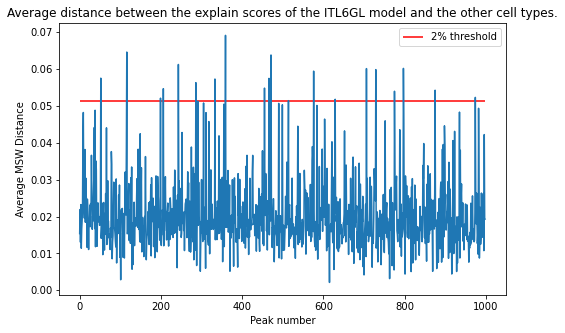

In [15]:
plot_similarity_matrix(itl6gl_sim_matrix, "ITL6GL")

The candidate peaks are those in which the average distance between the explain scores of the ITL6GL model and the explain scores of the rest of the models is in the top 2% (above red line). 

In [16]:
num_peaks = int(0.98*len(itl6gl_sim_matrix[0]))
candidate_peaks = np.argpartition(np.sum(itl6gl_sim_matrix, axis = 0), num_peaks)[num_peaks:]

###### Our candidates for ITL6GL specificity

In [18]:
print(candidate_peaks)
itl6gl_peaks.iloc[candidate_peaks]

[514 455 199 286 775 206 875 974 629 333  52 471 243 797 576 706 729 116
 359 466]


,chr,start,end,peak,label,phastcons_mean,phastcons_max,phylop_mean,phylop_max,itl6gl_jsd,itl6gl_jaccard
514,chr10,91803443,91803970,cCREs57875,chr10:91803443-91803970_cCREs57875,0.99788,1.000,1.25784,2.750,0.654008,0.625000
455,chr4,85488707,85489220,cCREs331862,chr4:85488707-85489220_cCREs331862,0.72262,0.920,0.36688,1.460,0.650820,0.857143
199,chr4,135682642,135683143,cCREs341775,chr4:135682642-135683143_cCREs341775,0.12192,0.224,0.12152,0.278,0.635808,0.833333
286,chr11,104713733,104714359,cCREs87884,chr11:104713733-104714359_cCREs87884,0.68876,0.750,0.51736,1.828,0.642008,0.777778
775,chrX,14666129,14666701,cCREs480461,chrX:14666129-14666701_cCREs480461,0.42794,0.881,0.39472,0.965,0.662183,0.777778
206,chrX,165518301,165518830,cCREs491101,chrX:165518301-165518830_cCREs491101,0.25430,0.941,0.52372,2.274,0.636556,0.400000
875,chr12,7334685,7335207,cCREs93113,chr12:7334685-7335207_cCREs93113,0.06288,0.393,0.29484,1.939,0.664678,0.777778
974,chr6,27396853,27397393,cCREs379922,chr6:27396853-27397393_cCREs379922,0.16296,0.248,0.24474,1.274,0.666709,0.600000
629,chr11,15218581,15219164,cCREs68747,chr11:15218581-15219164_cCREs68747,0.37736,0.442,0.19762,0.278,0.657976,0.791667
333,chr16,41101186,41101710,cCREs190381,chr16:41101186-41101710_cCREs190381,0.13332,0.604,0.36362,1.955,0.645366,0.428571


#### Candidates ITL6GL
<img src="images/itl6gl455.png" alt="drawing" style="width:800px;"/>


<img src="images/itl6gl514.png" alt="drawing" style="width:800px;"/>

<img src="images/itl6gltomtom.png" alt="drawing" style="width:800px;"/>



### CLAGL specific peaks analysis

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

In [5]:
explain_scores = {}
clagl_peaks = pd.read_csv(paths["peaks"]["clagl"], sep='\t')
print("Cell Type:")
for celltype in paths["suffixes"]:
    print(celltype)
    # Load all explain scores as lists of numpy arrays for the assumed CLAGL specific peaks
    explain_scores[celltype] = bw_to_np(clagl_peaks, pyBigWig.open(paths["explain_scores"][celltype]))

Cell Type:
clagl
d1msn
d2msn
itl6gl
ptgl
pvga
sstga
vipga


In [13]:
clagl_sim_matrix = create_similarity_matrix(explain_scores, max_sliding_window_diff, "clagl")

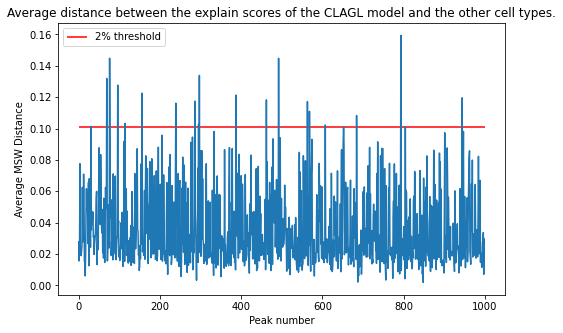

In [24]:
plot_similarity_matrix(clagl_sim_matrix, "CLAGL")

In [25]:
num_peaks = int(0.98*len(clagl_sim_matrix[0]))
candidate_peaks = np.argpartition(np.sum(clagl_sim_matrix, axis = 0), num_peaks)[num_peaks:]

In [26]:
print(candidate_peaks)

[804  30 944 462  69  76 568  96 492 387 684 114 607 156 297 295 286 239
 793 563]


### Our candidates for CLAGL specificity

In [27]:
clagl_peaks.iloc[candidate_peaks]

,chr,start,end,peak,label,phastcons_mean,phastcons_max,phylop_mean,phylop_max,clagl_jsd,clagl_jaccard
804,chr12,39916240,39916792,cCREs99200,chr12:39916240-39916792_cCREs99200,0.81694,1.000,1.05826,2.756,0.604706,0.250000
30,chr16,83039626,83040160,cCREs197982,chr16:83039626-83040160_cCREs197982,0.96258,0.999,1.01340,2.238,0.487730,0.000000
944,chr1,63692795,63693333,cCREs11769,chr1:63692795-63693333_cCREs11769,0.31466,0.429,0.16810,0.278,0.612342,0.000000
462,chr13,34845840,34846341,cCREs121171,chr13:34845840-34846341_cCREs121171,0.90740,0.923,0.22858,0.278,0.581661,0.666667
69,chr11,28850367,28850870,cCREs71270,chr11:28850367-28850870_cCREs71270,0.16626,0.887,0.27862,0.934,0.516523,0.333333
76,chr15,44564134,44564666,cCREs169425,chr15:44564134-44564666_cCREs169425,0.97432,1.000,1.85856,3.185,0.521930,0.000000
568,chr13,111999080,111999637,cCREs137086,chr13:111999080-111999637_cCREs137086,0.75560,0.893,0.35058,1.233,0.589981,0.000000
96,chr14,11175629,11176162,cCREs139530,chr14:11175629-11176162_cCREs139530,0.27296,0.948,0.50396,1.966,0.528160,0.333333
492,chr4,55155301,55155830,cCREs326398,chr4:55155301-55155830_cCREs326398,0.34670,0.485,0.38882,1.322,0.584149,0.000000
387,chr4,107392457,107392969,cCREs336478,chr4:107392457-107392969_cCREs336478,0.32482,0.758,0.42084,2.003,0.574996,0.000000


#### Candidate 1 (chr16:83039626-83040160) 

Candidate 1 actually has 2 examples of motifs that pop up only in CLAGL.

<img src="images/candidate1.png" alt="drawing" style="width:600px;"/>
<img src="images/candidate1bis.png" alt="drawing" style="width:600px;"/>

Looking up the second candidate motif (TGACATTT) in TOM TOM yields the following match in mouse DNA:

<img src="images/candidate1tomtom.png" alt="drawing" style="width:600px;"/>

#### Candidate 3 (chr5:9943620-9944154)

<img src="images/candidate3.png" alt="drawing" style="width:600px;"/>

Candidate 16 (chr16:51277483-51277990) yields the same motif as candidate 3 and the second motif of candidate 1.

#### Candidate 9 (chr4:55155301-55155830)

<img src="images/candidate492.png" alt="drawing" style="width:600px;"/>
<img src="images/candidate492tomtom.png" alt="drawing" style="width:600px;"/>

Notice that this is the same motif as in candidate 1, and has a good match with a human transcription factor.




### SSTGA specific peaks analysis

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

We'll reproduce the same steps we executed for CLAGL.

In [29]:
explain_scores = {}
sstga_peaks = pd.read_csv(paths["peaks"]["sstga"], sep='\t')
print("Cell Type:")
for celltype in paths["suffixes"]:
    print(celltype)
    # Load all explain scores as lists of numpy arrays for the assumed CLAGL specific peaks
    explain_scores[celltype] = bw_to_np(sstga_peaks, pyBigWig.open(paths["explain_scores"][celltype]))

Cell Type:
clagl
d1msn
d2msn
itl6gl
ptgl
pvga
sstga
vipga


In [30]:
sstga_sim_matrix = create_similarity_matrix(explain_scores, max_sliding_window_diff, "sstga")

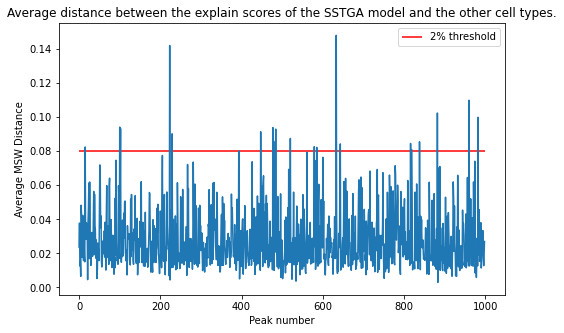

In [31]:
plot_similarity_matrix(sstga_sim_matrix, "SSTGA")

In [32]:
num_peaks = int(0.98*len(sstga_sim_matrix[0]))
candidate_peaks = np.argpartition(np.sum(sstga_sim_matrix, axis = 0), num_peaks)[num_peaks:]

### Our candidates for SSTGA specificity

In [34]:
print(candidate_peaks)
sstga_peaks.iloc[candidate_peaks]

[819 585  15 643 816 579 838 479 982 520 882 633 223 484 229 477 960 100
 447 102]


,chr,start,end,peak,label,phastcons_mean,phastcons_max,phylop_mean,phylop_max,sstga_jsd,sstga_jaccard
819,chr19,34605481,34606020,cCREs242568,chr19:34605481-34606020_cCREs242568,0.44680,0.842,0.39616,0.899,0.531396,0.545455
585,chr7,24741078,24741644,cCREs407055,chr7:24741078-24741644_cCREs407055,0.33260,0.483,0.17034,0.278,0.518746,0.700000
15,chr3,70287290,70287840,cCREs298235,chr3:70287290-70287840_cCREs298235,0.11292,0.139,0.13534,1.526,0.412196,0.100000
643,chr10,120662076,120662674,cCREs64513,chr10:120662076-120662674_cCREs64513,0.81176,1.000,0.74758,2.951,0.522387,0.466667
816,chr2,103559959,103560480,cCREs268596,chr2:103559959-103560480_cCREs268596,0.84258,0.884,0.21016,0.278,0.531274,0.700000
579,chr3,44958217,44958788,cCREs292984,chr3:44958217-44958788_cCREs292984,0.42884,0.936,0.51550,2.378,0.517900,0.416667
838,chr10,66635003,66635566,cCREs52162,chr10:66635003-66635566_cCREs52162,0.49462,0.994,0.49238,2.008,0.532635,0.300000
479,chr12,26922187,26922773,cCREs96252,chr12:26922187-26922773_cCREs96252,0.54782,0.999,0.44788,1.081,0.510593,0.500000
982,chr5,69473524,69474043,cCREs358982,chr5:69473524-69474043_cCREs358982,0.30316,0.501,0.16392,0.278,0.540065,0.818182
520,chr5,99092710,99093512,cCREs364166,chr5:99092710-99093512_cCREs364166,0.53304,0.848,0.32712,0.569,0.513621,0.555556


#### Candidate 0 SSTGA
<img src="images/sstgacandidate00.png" alt="drawing" style="width:800px;"/>


#### Candidate 3 SSTGA

<img src="images/sstgacandidate15.png" alt="drawing" style="width:800px;"/>



## Groups


<img src="images/groupings.png" alt="drawing" style="width:800px;"/>

